# GRACE Foundation Model Distillation

## Overview

This notebook demonstrates **knowledge distillation** for a GRACE foundation model. The process involves:

1. **Training Data Generation**: Create diverse structures from Materials Project (MP) data
2. **Model Evaluation**: Use a finetuned foundation model to predict energies, forces, and stresses
3. **Data Augmentation**: Apply structural deformations and perturbations to expand the dataset
4. **Dataset Creation**: Compile all predictions into a distilled dataset for training a smaller student model

### What is Distillation?

Distillation transfers knowledge from a large pretrained model (teacher) to a smaller model (student). Instead of computing expensive DFT calculations, we use the teacher model's predictions as training targets. This significantly reduces computational cost while maintaining accuracy.

### Workflow

```
Materials Project Structures + DFT calculations
         ↓
    Finetune founational GRACE-2L-OMAT-medium-ft-E
         ↓
     GRACE-2L-ft-AlLi
         ↓
   Structural Deformations (Murnaghan, Random Strains)
         ↓
   Model Predictions (E, F, σ)
         ↓
   Distilled Training Dataset
```

In [1]:
%pylab inline

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


## Step 1: Import Libraries

First, we import necessary libraries for data handling, ASE structures, and GRACE model evaluation.

In [2]:
import pandas as pd

In [3]:
from amstools.sources import fetch_structures, fetch_mp_reference_df

In [4]:
from amstools.qatoms import  QAtoms

In [5]:
from amstools.properties import *

In [6]:
from tensorpotential.calculator import grace_fm, TPCalculator

[tensorpotential] Info: Environment variable TF_USE_LEGACY_KERAS is automatically set to '1'.


2026-02-27 15:24:41.698544: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1772202281.709429  695838 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1772202281.712753  695838 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1772202281.721530  695838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772202281.721538  695838 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1772202281.721540  695838 computation_placer.cc:177] computation placer alr

In [7]:
#MP_API_KEY="YOUR_API_KEY"

## Step 2: Load Reference Structures from Materials Project

We fetch reference structures for Al and Li from the Materials Project database. These structures serve as the basis for our distilled dataset. We limit to structures with ≤32 atoms for computational efficiency.

**Parameters:**
- `elements`: ['Al','Li'] - Elements to include
- `max_atoms`: 32 - Maximum system size
- `cache_dir`: Local cache for downloaded structures

In [8]:
ref_df=fetch_mp_reference_df(['Al','Li'], 
                             # mp_api_key=MP_API_KEY,
                             max_atoms=32,
                             cache_dir='../../1-AlLi-GRACE-2LAYER/0-data/AlLi_Materials_Project/')

### Loaded Structures

Below we can see the reference dataframe containing all downloaded structures:

In [9]:
ref_df

,name,ase_atoms,e_per_atom,e_formation_per_atom,e_chull_dist_per_atom
0,Al__mp-134,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",NaN,0.000000,0.000000
1,Al__mp-2647008,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",NaN,0.032078,0.032078
2,Al__mp-1183144,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",NaN,0.010481,0.010481
3,Li__mp-51,"(Atom('Li', [np.float64(0.0), np.float64(0.0),...",NaN,0.001672,0.001672
4,Li__mp-135,"(Atom('Li', [np.float64(0.0), np.float64(0.0),...",NaN,0.009651,0.009651
5,Li__mp-976411,"(Atom('Li', [np.float64(0.0), np.float64(0.0),...",NaN,0.005889,0.005889
6,Li__mp-1018134,"(Atom('Li', [np.float64(4.618009551014942), np...",NaN,0.000000,0.000000
7,Li__mp-1103107,"(Atom('Li', [np.float64(1.379696372079909), np...",NaN,0.055379,0.055379
8,Li__mp-1063005,"(Atom('Li', [np.float64(0.0), np.float64(0.0),...",NaN,0.015671,0.015671
9,Li__mp-10173,"(Atom('Li', [np.float64(-1.1807313597921131e-0...",NaN,0.005988,0.005988


## Step 3: Load the Finetuned Teacher Model

We load the finetuned GRACE foundation model that has been trained on Al-Li data. This model serves as the **teacher** that will provide predictions for the distilled dataset.

The model is loaded as an ASE calculator, allowing us to compute:
- Potential energies (E)
- Atomic forces (F)
- Stress tensors (σ)

In [10]:
calc=TPCalculator("../3a-finetuning/seed/1/final_model/")

2026-02-27 15:24:47.915033: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


## Step 4: Prepare Structure Dictionary

Convert the Materials Project structures into a dictionary for easy access. We also add some random structures to increase dataset diversity.

In [11]:
struct_dict=ref_df.set_index("name")['ase_atoms'].to_dict()

### Adding Random Structures for Dataset Diversity

We create some random defective structures by randomly replacing atoms with Li in a 2×2×2 supercell of bulk Al. This adds diversity to the training set and helps the model generalize better.

In [12]:
for i in range(20):
    small_structure = (QAtoms.bulk("Al",cubic=True)*(2,2,2)).sample(frac=0.01+0.01*i, random_state=i).set(element='Li')
    print(f"random_struct_{i} has {len(small_structure)} atoms and {small_structure.get_chemical_formula()}.")
    struct_dict[f'random_struct_{i}'] = small_structure

random_struct_0 has 32 atoms and Al31Li.
random_struct_1 has 32 atoms and Al31Li.
random_struct_2 has 32 atoms and Al31Li.
random_struct_3 has 32 atoms and Al30Li2.
random_struct_4 has 32 atoms and Al30Li2.
random_struct_5 has 32 atoms and Al30Li2.
random_struct_6 has 32 atoms and Al29Li3.
random_struct_7 has 32 atoms and Al29Li3.
random_struct_8 has 32 atoms and Al29Li3.
random_struct_9 has 32 atoms and Al28Li4.
random_struct_10 has 32 atoms and Al28Li4.
random_struct_11 has 32 atoms and Al28Li4.
random_struct_12 has 32 atoms and Al27Li5.
random_struct_13 has 32 atoms and Al27Li5.
random_struct_14 has 32 atoms and Al27Li5.
random_struct_15 has 32 atoms and Al26Li6.
random_struct_16 has 32 atoms and Al26Li6.
random_struct_17 has 32 atoms and Al26Li6.
random_struct_18 has 32 atoms and Al25Li7.
random_struct_19 has 32 atoms and Al25Li7.


## Step 5: Generate Structural Deformations & Collect Model Predictions

This is the core of the distillation process. For each structure, we apply multiple deformations:

### Pipeline Components:

1. **StepwiseOptimizer**: Relaxes atomic positions using the GRACE model (keeps cell fixed)
2. **MurnaghanCalculator**: Applies isotropic volume deformations to find equation of state
3. **RandomDeformationCalculator**: Applies random atomic displacements and cell strains

### Parameters:
- **supercell_size**: (1,1,2) - Creates slab-like geometry
- **nsample**: 3 - Number of random deformation samples
- **random_atom_displacement**: 0.5 Å - Magnitude of atomic perturbations
- **random_cell_strain**: 0.15 - Magnitude of cell strains
- **volume_range**: 0.125 - Volume deformation range (±12.5%)
- **num_volume_deformations**: 5 - Number of different volumes to sample

For each deformation, the model predicts E, F, σ which become training data.

In [13]:
pipelines_dict={}

In [14]:
for i,(struct_name, at) in enumerate(struct_dict.items()):
    # Only process each structure once
    if struct_name not in pipelines_dict:
        at.calc = calc  # Attach the finetuned GRACE model as calculator
        
        # Build the deformation pipeline
        pipe = (
            # Option 1: Use nearest neighbor distance scanning
            # NearestNeighboursExpansionCalculator(nn_distance_range=(2,7), nn_distance_step=1) 
            
            # Step 1: Atomic relaxation (fixed cell)
            StepwiseOptimizer() 
            
            # Step 2: Equation of state (isotropic volume changes)
            + MurnaghanCalculator(optimize_deformed_structure=False) 
            
            # Step 3: Random deformations (supercell + atomic displacements + cell strains)
            + RandomDeformationCalculator(
                supercell_size=(2,2,2) if len(at)<32 else (2,2,1),           # Create supercell geometry
                nsample=3,                        # 3 random samples 
                random_atom_displacement=0.5,     # Å - random atomic perturbations
                random_cell_strain=0.15,          # Random cell deformations
                volume_range=0.125,                # ±12.5% volume change
                num_volume_deformations=5,        # Sample 5 different volumes
                seed = i
            )
        )

        # break
        # Execute the pipeline on this structure
        # This generates all deformed configurations automatically
        pipe.run(init_structure=at, engine=calc, verbose=True)
        pipelines_dict[struct_name] = pipe
        

2026-02-27 15:24:50,224 - root - INFO - =======================
2026-02-27 15:24:50,224 - root - INFO - Step: optimization
Processing: optimized_structure (1 atom(s)):   0%|          | 0/1 [00:00<?, ?it/s]WARNING: All log messages before absl::InitializeLog() is called are written to STDERR
I0000 00:00:1772202290.706400  695838 service.cc:152] XLA service 0x17effe90 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1772202290.706437  695838 service.cc:160]   StreamExecutor device (0): Host, Default Version
2026-02-27 15:24:50.924183: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
I0000 00:00:1772202292.454039  695838 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.
Processing: optimized_structure (1 atom(s)): 100%|██████████| 1/1 [00:02<00:00,  2.34s/it]
2026-0

## Step 6: Extract Predictions and Create DataFrame

Now we collect the energies, forces, and stresses from all deformed structures. Each entry in the resulting dataframe will contain:
- **Energy** (eV): Total potential energy
- **Forces** (eV/Å): Atomic forces
- **Stress** (eV/A$^3$): Stress tensor
- **ASE Atoms object**: The atomic structure

This becomes our **distilled training dataset**.

In [16]:
from tqdm import tqdm

In [17]:
results_data = []

# Iterate through all structures and their deformations
for struct_name, pipe in tqdm(pipelines_dict.items()):
    # Each pipeline step generates output structures
    for step_name, step in pipe.steps.items():
        # Each step can have multiple deformed structures
        for def_name, at in step.output_structures_dict.items():
            # Create a unique identifier for this structure
            name = f"{struct_name}/{step_name}/{def_name}"
            
            # Attach calculator and evaluate
            at.calc = calc 
            energy = at.get_potential_energy()
            forces = at.get_forces()
            stress = at.get_stress()
            
            # Store the data
            results_data.append({
                "name": name, 
                "ase_atoms": at, 
                "energy": energy,
                "forces": forces, 
                "stress": stress
            })
            
            # Detach calculator (free memory)
            at.calc = None


100%|██████████| 39/39 [05:21<00:00,  8.24s/it]


In [18]:
df_dist=pd.DataFrame(results_data)

### Computing Per-Atom Properties

Calculate useful statistics for each entry:

In [19]:
df_dist['nat']=df_dist['ase_atoms'].map(len)

In [20]:
df_dist['energy_per_atom']=df_dist['energy']/df_dist['nat']

In [21]:
df_dist

,name,ase_atoms,energy,forces,stress,nat,energy_per_atom
0,Al__mp-134/optimization/optimized_structure,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",-3.754462,"[[0.0, 0.0, 0.0]]","[-2.975860758364518e-07, -2.8705801571299197e-...",1,-3.754462
1,Al__mp-134/murnaghan/strain_0_9,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",-3.704738,"[[0.0, 0.0, 0.0]]","[-0.06635673293253207, -0.06635671810562635, -...",1,-3.704738
2,Al__mp-134/murnaghan/strain_0_92,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",-3.723876,"[[0.0, 0.0, 0.0]]","[-0.050047719663105776, -0.050047705780992977,...",1,-3.723876
3,Al__mp-134/murnaghan/strain_0_9400000000000001,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",-3.737920,"[[0.0, 0.0, 0.0]]","[-0.035417253992588736, -0.03541724099712447, ...",1,-3.737920
4,Al__mp-134/murnaghan/strain_0_9600000000000001,"(Atom('Al', [np.float64(0.0), np.float64(0.0),...",-3.747392,"[[0.0, 0.0, 0.0]]","[-0.02228283062327546, -0.022282818475404444, ...",1,-3.747392
...,...,...,...,...,...,...,...
1048,random_struct_19/randomdeformation/rnd_2__vol_...,"(Atom('Al', [np.float64(-0.40489716723283475),...",2.982599,"[[-2.414855417212035, -6.610281252387178, 12.7...","[-0.37794380347258555, -0.5375789485475247, -0...",128,0.023302
1049,random_struct_19/randomdeformation/rnd_2__vol_...,"(Atom('Al', [np.float64(-0.41431673869821817),...",-52.775444,"[[-2.289750021560093, -5.690048437092457, 11.7...","[-0.3008919533133577, -0.43736801761356875, -0...",128,-0.412308
1050,random_struct_19/randomdeformation/rnd_2__vol_...,"(Atom('Al', [np.float64(-0.4233264331506395), ...",-98.156572,"[[-2.1391909417914214, -4.897711744291678, 10....","[-0.23979301961057603, -0.3570107727773984, -0...",128,-0.766848
1051,random_struct_19/randomdeformation/rnd_2__vol_...,"(Atom('Al', [np.float64(-0.43196812391144523),...",-135.200395,"[[-1.9943328478686633, -4.217156195720355, 9.9...","[-0.19116182026777298, -0.29224497521429504, -...",128,-1.056253


### System Size Distribution

Distribution of the number of atoms in each structure:

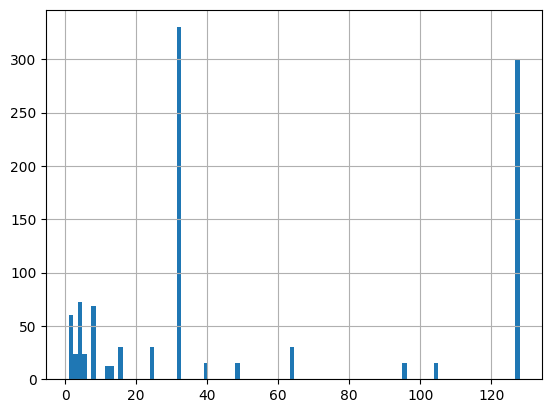

In [22]:
df_dist['nat'].hist(bins=100);

## Step 7: Analyze Dataset Distribution

Let's visualize the properties of the distilled dataset to understand its characteristics:

### Energy Distribution

Energy per atom across all structures. Different peaks correspond to different phases and compositions:

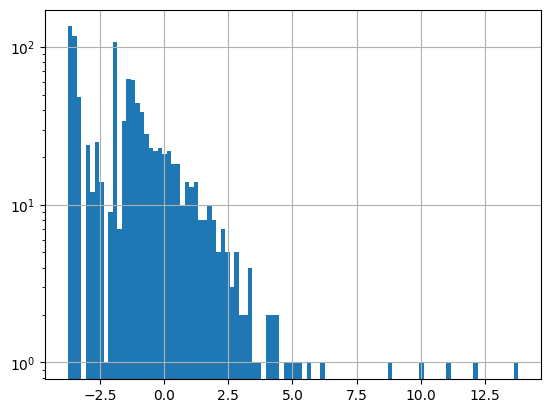

In [23]:
df_dist['energy_per_atom'].hist(bins=100);
plt.yscale('log')

### Force Distribution

Distribution of forces (log scale). Most forces are small with occasional large forces from deformed structures:

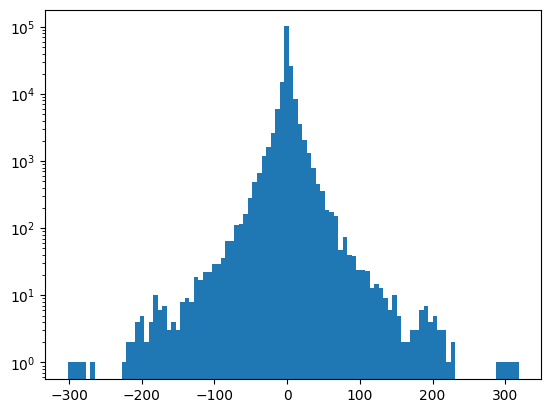

In [24]:
plt.hist(np.vstack(df_dist['forces']).flatten(), bins=100);
plt.yscale('log')

### Stress Distribution

Stress components (in GPa) show the range of pressures sampled. Log scale reveals even small stresses are well-sampled:

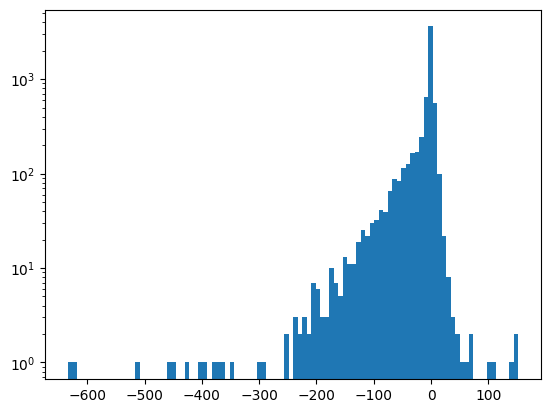

In [25]:
plt.hist(np.vstack(df_dist['stress']).flatten()*160.2, bins=100);
plt.yscale('log')

## Step 8: Save the Distilled Dataset

Export the complete distilled dataset as a compressed pickle file. This dataset can now be used to train a smaller, faster student model using the gracemaker training pipeline.

**Output file**: `distilled_AlLi_dataset.pkl.gz` - Contains all structures with their E, F, σ predictions from the teacher model.

In [26]:
df_dist.to_pickle("distilled_AlLi_dataset.pkl.gz")

## Summary

We have successfully created a **distilled dataset** for training a student GRACE model:

### Key Achievements:

1. ✅ **Loaded Materials Project structures** - Gathered reference data for Al and Li
2. ✅ **Applied structural deformations** - Generated diverse configurations through:
   - Atomic relaxation (StepwiseOptimizer)
   - Equation of state sampling (Murnaghan deformations)
   - Random perturbations (displacements + strains)
3. ✅ **Collected predictions** - Used finetuned GRACE foundation model to evaluate all structures
4. ✅ **Created training dataset** - Compiled energies, forces, and stresses for ~1000+ configurations
5. ✅ **Saved for further use** - Output: `distilled_AlLi_dataset.pkl.gz`

### Next Steps:

The distilled dataset can now be used to:
- Train a lightweight student model (GRACE/FS)
- Deploy on CPU-only systems or use KOKKOS acceleration
- Fine-tune with additional DFT data for hybrid training

### Computational Advantages:

- **No expensive DFT calculations** needed (teacher model does predictions)
- **Diverse structure sampling** ensures good coverage of configuration space
- **Transferable knowledge** from pretrained foundation model
- **Faster inference** with smaller student models compared to foundation model